# Framing

In [1]:
%run ../setup.ipynb

The key idea behind the short-time Fourier transform is to divide a long signal up into short pieces, and analyze each piece separately.
While the frequency content of a signal may change over long periods of time, real signals tend to be approximately stationary if we look only at short fragments.

````{margin} Frames
"Frame" is one of those unfortunate terms in digital signal processing that has multiple meanings, depending on context.
This makes it very confusing for newcomers!

The definition we'll use is that a "frame" corresponds to a relatively small number of audio samples, e.g., an array of 50 samples:
```{math}
\left[x[1000], x[1001], x[1002], \dots, x[1049]\right].
```

The alternate definition that you may see elsewhere defines a "frame" for a multi-channel signal (e.g., a stereo mix with left- and right-channels) as the array of sample values for each channel at a specific sample index, e.g., the length-2 array $[x_L[1000], x_R[1000]]$.
````

These fragments are known as **frames**, and typically span a few thousand samples at a time.
The number of samples in a frame is conveniently known as the **frame length**, which we'll denote by $N_F$.
The frame length determines the duration of the fragment being analyzed ($t = N_F / f_s$).

In addition to the frame length, we also must decide how many frames to take.
This is controlled by the **hop length**: the number of samples between frames, which we will denote by $N_H$.

The framing process is illustrated by {numref}`framing`.

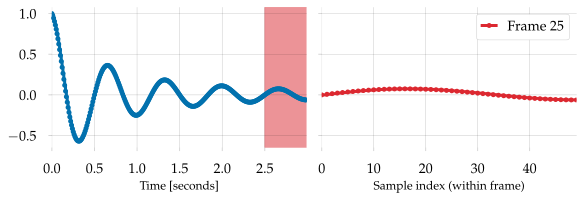

In [50]:
fig, (ax, axf) = plt.subplots(ncols=2, sharey=True, figsize=figaspect(1./3))

fs = 100
N = 300
f0 = 1.5

NF = 50
NH = 10

n = np.arange(N)
nf = np.arange(NF)
t = n / fs
x = np.cos(2 * np.pi * f0 * t) /(1 + t)**2


samples = ax.step(t, x, where='post', marker='.')[0]
span = ax.axvspan(t[0], t[NF], zorder=-1, color=colors[1], alpha=0.5)
ax.label_outer()
ax.set(xlabel='Time [seconds]')
frame = axf.step(nf, x[:NF], where='post', marker='.', label='Frame  0', color=colors[1])[0]
axf.set(xlabel='Sample index (within frame)')

leg = axf.legend(loc='upper right')

def init():
    return span, frame, leg

def animate(n):
    frame.set_data(nf, x[n * NH:n*NH + NF])
    frame.set_label('Frame {:2d}'.format(n))
    leg.texts[0].set_text(frame.get_label())
    xy = span.get_xy()
    # Offset all coordinates by the start of the frame
    xy[:, 0] = t[n * NH]
    # coords 3 and 4 should offset by the frame length as well
    xy[2:4,0] += t[NF]
    span.set_xy(xy)
    return frame, leg
    
    
animation = FuncAnimation(fig, animate,
                               init_func=init,
                               frames=1 + (N - NF)//NH, interval=1000,
                               blit=True)

glue('framing', animation, display=False)

In [51]:
animation

```{glue:figure} framing
---
name: framing
---

*Left*: a signal of $N=300$ samples taken at $f_s=100$.
*Right*: the frames constructed from the signal with frame length $N_F=50$ and hop length $N_H=10$.
```

Combining these two quantities, the $n$th sample of the $k$th frame is given by

```{math}
y[k, n] = x[k \cdot N_H + n] \quad\quad \text{For } n = 0, 1, \dots, N_F - 1
```

Here, we are using a two-dimensional array $y$ to represent the *framed signal*: the first index $k$ selects which frame, and the second index $n$ selects which sample within the frame.

The $k$th frame, therefore, is the slice of the signal from sample indices $k \cdot N_H$ to $k \cdot N_H + N_F - 1$.

Equivalently, in Python, the $k$th frame would by computed by the array slice:

```{code-block} python
x[k * NH:k * NH + NF]
```

Using some dimensional analysis, we can convert frame indices to time as well:

```{math}
\left(k \left[\text{frames}\right] \right) \cdot 
\left(N_H \frac{\left[\text{samples}\right]}{\left[\text{frame}\right]} \right) \cdot 
\left(t_s \frac{\left[\text{seconds}\right]}{\left[\text{sample}\right]} \right)
= k \cdot N_H \cdot t_s \left[\text{seconds} \right] = k \cdot \frac{N_H}{f_s} \left[\text{seconds}\right].
```

From this, we can observe that $N_H / f_s$ can be interpreted as the (time) period between frames.
Equivalently, its reciprocal $f_s / N_H$ gives us the number of frames per second, a quantity known as the **frame rate**.

## How many frames are there?

Calculating the exact number of frames in a signal from the framing parameters can be a little subtle, but it's not too hard if we're careful.

It can be helpful to think of a few of extreme cases:

1. What if $N_F = N$, so that the frame length is exactly the same as the signal length?  In this case, there should be only 1 frame.  The hop length does not matter here because any index offset other than 0 would push the frame off the end of the input array, and we would not have a full frame.
2. What if $N_F = N_H = 1$?  In this case, each sample is a frame by itself, so we should have $N$ frames (one per sample).
3. What if $N_F = 1$ and $N_H = 2$?  In this case, we're effectively decimating the signal by a factor of 2 (taking every other sample), so we should have $N/2$ frames (if $N$ is even) or $(N-1)/2$ (if $N$ is odd).

More generally, how many steps $k$ of size $N_H$ we can take before $k \cdot N_H + N_F \geq N$?
Rearranging this inequality gives us the following formula.

````{admonition} Counting frames
:class: information

A signal of $N$ samples, with frame length $N_F \leq N$ and hop length $N_H$ will produce $K$ frames, where

```{math}
:label: frame-count
K = 1 + \left\lfloor\frac{N - N_F}{N_H}\right\rfloor .
```
````
The "extra" $1+$ comes from the fact that frame $k=0$ does not invoke a step by the hop length; if we did not have this extra $1$, the result would not agree with the "extreme" cases identified above.

Note that {eq}`frame-count` divides the signal length (minus one frame) by the hop length.
However, the hop length generally may not evenly divide $N-N_F$, which is why we round this ratio down so that only **full frames** are counted.

The Python equivalent of {eq}`frame-count` is:

```{code-block} python
# Integer division // rounds down
N_frames = 1 + (len(x) - N_F) // N_H
```

Now that we have a handle on how to apply framing to a signal, we are ready to define the short-time Fourier transform.